In [1]:
!unzip drive/MyDrive/datasets/garbage_types.zip -d ./data

Streaming output truncated to the last 5000 lines.
  inflating: ./data/Garbage classification/paper/paper484.jpg  
  inflating: ./data/__MACOSX/Garbage classification/paper/._paper484.jpg  
  inflating: ./data/Garbage classification/paper/paper71.jpg  
  inflating: ./data/__MACOSX/Garbage classification/paper/._paper71.jpg  
  inflating: ./data/Garbage classification/paper/paper65.jpg  
  inflating: ./data/__MACOSX/Garbage classification/paper/._paper65.jpg  
  inflating: ./data/Garbage classification/paper/paper490.jpg  
  inflating: ./data/__MACOSX/Garbage classification/paper/._paper490.jpg  
  inflating: ./data/Garbage classification/paper/paper269.jpg  
  inflating: ./data/__MACOSX/Garbage classification/paper/._paper269.jpg  
  inflating: ./data/Garbage classification/paper/paper255.jpg  
  inflating: ./data/__MACOSX/Garbage classification/paper/._paper255.jpg  
  inflating: ./data/Garbage classification/paper/paper533.jpg  
  inflating: ./data/__MACOSX/Garbage classification/pap

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torchvision.models import ConvNeXt_Tiny_Weights
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
import os

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), # resize image
    transforms.CenterCrop((224, 224)), # center crop image
    transforms.ToTensor(), # convert to Pytorch tensor
    transforms.Normalize((0.485, 0.456, 0.406),(0.229,0.224,0.225)) # normalize
])

dataset= torchvision.datasets.ImageFolder(
    root='./data/Garbage classification',
    transform=transform
)

# Split the dataset into training, validation, and test sets
train_size = int(0.6 * len(dataset))
val_size = int(0.35 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])



CLASSES = dataset.class_to_idx  # this is for labeling predicted values + for output layer

train_loader = DataLoader(train_set, batch_size=128)
val_loader = DataLoader(val_set, batch_size=128)

print(dataset[0][0].shape)
print(CLASSES)

# Print the sizes of the resulting sets
print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

torch.Size([3, 224, 224])
{'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
Train set size: 1516
Validation set size: 884
Test set size: 127


In [ ]:
def TrashTypeModel(num_classes):
    
    # load the pretrained model because what's the point of re-inventing the wheel??
    model = models.convnext_tiny(weights=ConvNeXt_Tiny_Weights.DEFAULT) # in the new version of PyTorch, you can't use pretrained=True
    
    # Freeze all the layers because we only want to train the new layers
    
    for param in model.parameters():
        # disable gradients because we don't need to include pretrained data in the backprop
        param.requires_grad = False
        
        
    # Replace the last layer with a MLP mixer with dropout
    
    model.classifier[-1] = nn.Sequential(
        nn.Linear(768, 256),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(256, num_classes)
    )
    
    return model

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
EPOCHS = 20
LR = 0.001
SAVE_PATH = os.path.join(os.getcwd(), "./models/trinity.pth")

print(DEVICE)

model = TrashTypeModel(len(CLASSES)).to(DEVICE)
params = model.parameters()
optimizer = torch.optim.Adam(model.classifier.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
loss_fn = nn.CrossEntropyLoss()
lr_scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.1, patience=3, verbose=True)

# track the mean loss and accuracy for each epoch

mean_accuracies = []
mean_losses = []
best_acc = 0

for epoch in range(EPOCHS):
    batch_accs = []
    batch_losses = []
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(DEVICE), target.to(DEVICE)
        
        # reset gradients
        optimizer.zero_grad()
        
        # forward pass + loss and accuracy
        y_hat = model(data)
        loss = loss_fn(y_hat, target)
        accuracy = (y_hat.argmax(1) == target).float().mean()
        
        # keep track of batch accuracy and loss
        batch_accs.append(accuracy)
        batch_losses.append(loss.item())
        
        # print the batch accuracy and loss
        
        if batch_idx % 5 == 0:
            print(f"Batch: {batch_idx+1}/{len(train_loader)} | Loss: {loss.item():.4f} | Accuracy: {accuracy * 100:.4f}")

        if accuracy > best_acc:
          # save the model
          best_acc = accuracy
          print("... Saving the model")
          torch.save(model.state_dict(), SAVE_PATH)
        
        # backprop
        loss.backward()
        optimizer.step()
        
    # calculate mean loss and accuracy for the epoch
    mean_acc, mean_loss = torch.mean(torch.tensor(batch_accs)), torch.mean(torch.tensor(batch_losses))
    
    # print the mean loss and accuracy for the epoch
    print("############################################################################################################")
    print(f"##     Epoch: {epoch+1}/{EPOCHS} | Loss: {mean_loss:.4f} | Accuracy: {mean_acc * 100:.4f}                ##")
    print("############################################################################################################")
    
    # append to the mean loss and accuracy lists for future plotting
    mean_accuracies.append(mean_acc)
    mean_losses.append(mean_loss)
    
    # update the learning rate to counter plateaus
    lr_scheduler.step(loss)

cuda


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /root/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth
100%|██████████| 109M/109M [00:01<00:00, 61.6MB/s]


Batch: 1/65 | Loss: 1.9372 | Accuracy: 13.2812
... Saving the model
... Saving the model
... Saving the model


/usr/local/lib/python3.9/dist-packages/PIL/Image.py:975: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


... Saving the model
... Saving the model
Batch: 6/65 | Loss: 1.2968 | Accuracy: 68.7500
... Saving the model
... Saving the model
... Saving the model
Batch: 11/65 | Loss: 0.7098 | Accuracy: 83.5938
... Saving the model
... Saving the model
Batch: 16/65 | Loss: 0.4855 | Accuracy: 85.9375
... Saving the model
Batch: 21/65 | Loss: 0.4857 | Accuracy: 85.1562
... Saving the model
... Saving the model
Batch: 26/65 | Loss: 0.2888 | Accuracy: 92.1875
Batch: 31/65 | Loss: 0.3221 | Accuracy: 89.8438
Batch: 36/65 | Loss: 0.3194 | Accuracy: 88.2812
Batch: 41/65 | Loss: 0.3641 | Accuracy: 89.8438
... Saving the model
Batch: 46/65 | Loss: 0.3855 | Accuracy: 88.2812
... Saving the model
Batch: 51/65 | Loss: 0.2720 | Accuracy: 93.7500
Batch: 56/65 | Loss: 0.3211 | Accuracy: 89.8438
Batch: 61/65 | Loss: 0.1601 | Accuracy: 95.3125
############################################################################################################
##     Epoch: 1/20 | Loss: 0.4852 | Accuracy: 85.8038           

Validation: Loss: 0.23238690197467804 | Accuracy: 92.1875
Validation: Loss: 0.1678241491317749 | Accuracy: 95.3125
Validation: Loss: 0.14542914927005768 | Accuracy: 93.75
Validation: Loss: 0.1690240055322647 | Accuracy: 95.3125
Validation: Loss: 0.13687238097190857 | Accuracy: 95.3125
Validation: Loss: 0.054773882031440735 | Accuracy: 96.875
Validation: Loss: 0.20764164626598358 | Accuracy: 91.40625
Validation: Loss: 0.18813954293727875 | Accuracy: 91.40625
Validation: Loss: 0.10663633048534393 | Accuracy: 97.65625
Validation: Loss: 0.10329926759004593 | Accuracy: 95.3125
Validation: Loss: 0.059165216982364655 | Accuracy: 96.875
Validation: Loss: 0.20913326740264893 | Accuracy: 94.53125
Validation: Loss: 0.07788993418216705 | Accuracy: 97.65625
Validation: Loss: 0.08429322391748428 | Accuracy: 97.65625
Validation: Loss: 0.10267205536365509 | Accuracy: 95.3125
Validation: Loss: 0.12830780446529388 | Accuracy: 94.53125
Validation: Loss: 0.12684810161590576 | Accuracy: 95.3125
Validation:

Text(0.5, 1.0, 'mean accuracies')

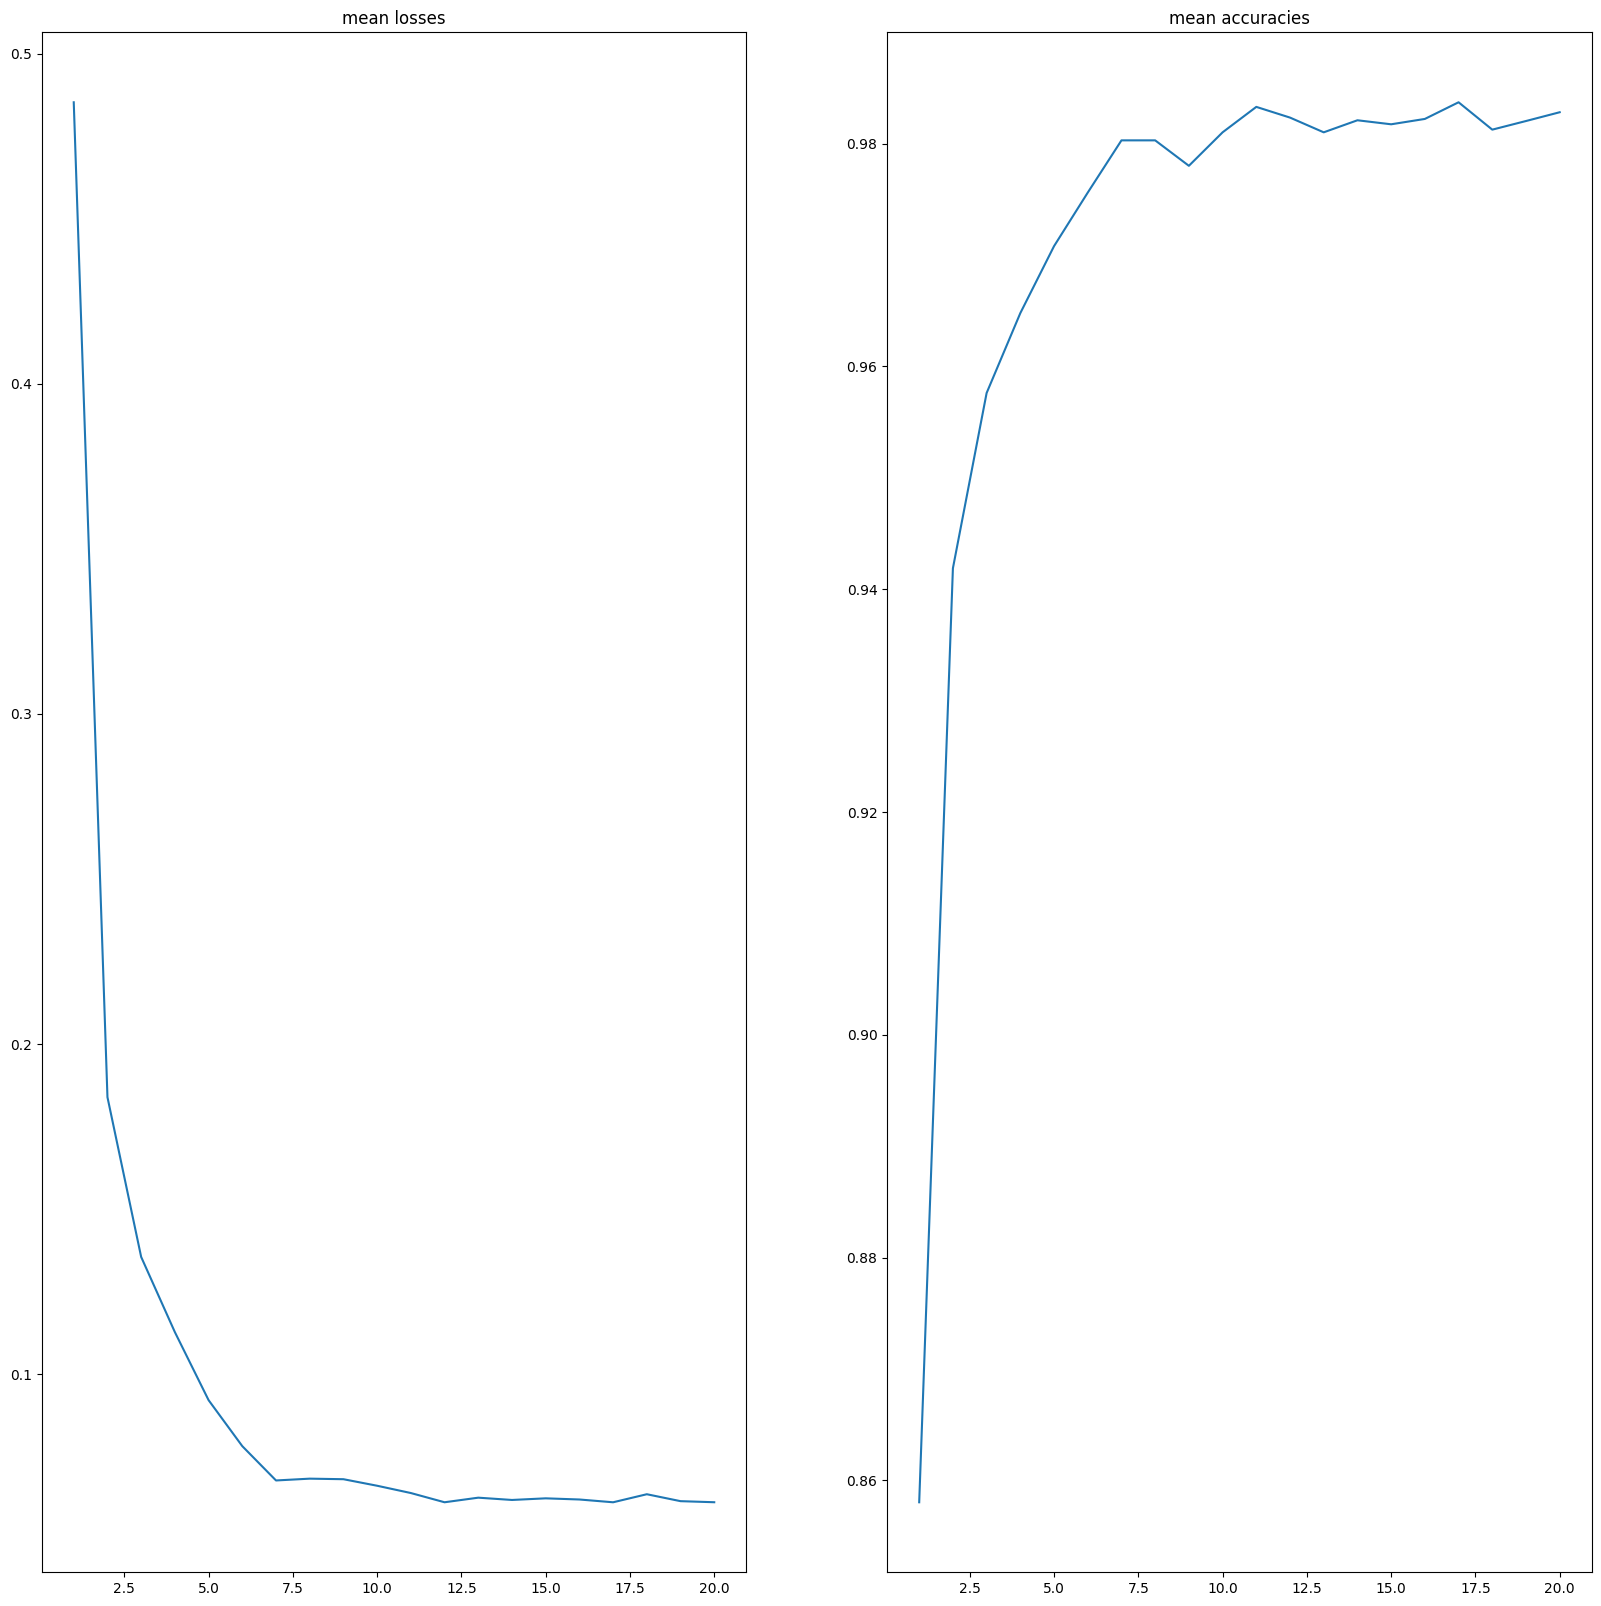

In [ ]:
def validate():
  model.load_state_dict(torch.load(SAVE_PATH))
  model.eval()

  with torch.no_grad():

    for batch_idx, (data, target) in enumerate(val_loader):
      data = data.to(DEVICE)
      target = target.to(DEVICE)

      y_hat = model(data)
      loss = loss_fn(y_hat, target)

      print(f"Validation: Loss: {loss.item()} | Accuracy: {(y_hat.argmax(dim=1) == target).float().mean() * 100}")

validate()

ep = [e+1 for e in range(EPOCHS)]
print(ep)

fig, ax = plt.subplots(1,2, figsize=(20,20))
ax[0].plot(ep, mean_losses)
ax[0].set_title("mean losses")

ax[1].plot(ep, mean_accuracies)
ax[1].set_title("mean accuracies")


paper
cardboard
cardboard


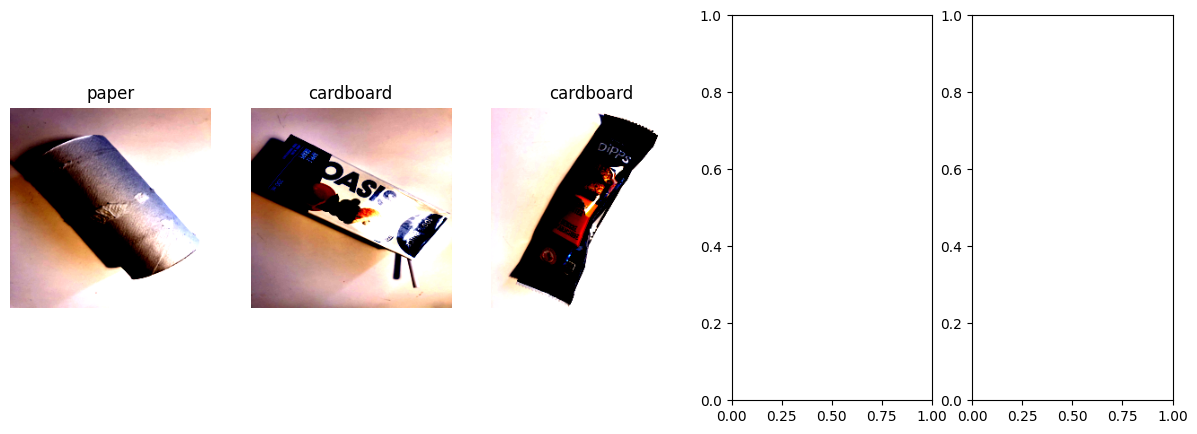

In [ ]:
# predict real image 

img1 = Image.open("IMG_2427.jpg")
transformed1 = transform(img1)

img2 = Image.open("IMG_2428.jpg")
transformed2 = transform(img2)

img3 = Image.open("IMG_2429.jpg")
transformed3 = transform(img3)

all_data = []
all_data.append(transformed1)
all_data.append(transformed2)
all_data.append(transformed3)


dl = DataLoader(all_data, batch_size=1)

model.load_state_dict(torch.load(SAVE_PATH))
model.eval()

preds = []

with torch.no_grad():

  for idx, data in enumerate(dl):
    data = data.to(DEVICE)

    y_hat = model(data)
    pred = y_hat.argmax(dim=1)
    item = list(CLASSES.keys())[pred]
    preds.append(item)
    print(item)

fig, axs = plt.subplots(1, 5, figsize=(15, 5))

for idx, data in enumerate(dl):
    img = data[0].numpy().transpose((1, 2, 0))
    axs[idx].imshow(img)
    axs[idx].axis('off')
    axs[idx].set_title(preds[idx])

plt.show()